In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("dark")
from tqdm import tqdm
import pickle

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal, AutoLaplaceApproximation
from pyro.infer import  Trace_ELBO,SVI,TraceMeanField_ELBO
from pyro.infer.importance import psis_diagnostic
from pyro.optim import Adam, ClippedAdam, AdagradRMSProp
from pyro.distributions.torch import TransformedDistribution
import torch.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS
from torch.distributions.utils import broadcast_all
import pyro.poutine as poutine
from pyro.ops.hessian import hessian

n = 10000

class BananaShaped(dist.TorchDistribution):
    arg_constraints = {"a": constraints.positive, "b": constraints.real}
    support = constraints.real_vector

    def __init__(self, a, b, rho=0.9):
        self.a, self.b, self.rho = broadcast_all(a, b, rho)
        self.mvn = dist.MultivariateNormal(
            torch.tensor([0.0, 0.0]),
            covariance_matrix=torch.tensor([[1.0, self.rho], [self.rho, 1.0]]),
        )
        super().__init__(event_shape=(2,))

    def sample(self, sample_shape=()):
        u = self.mvn.sample(sample_shape)
        u0, u1 = u[..., 0], u[..., 1]
        a, b = self.a, self.b
        x = a * u0
        y = (u1 / a) + b * (u0**2 + a**2)
        return torch.stack([x, y], -1)

    def log_prob(self, x):
        x, y = x[..., 0], x[..., 1]
        a, b = self.a, self.b
        u0 = x / a
        u1 = (y - b * (u0**2 + a**2)) * a
        return self.mvn.log_prob(torch.stack([u0, u1], dim=-1))
    
    
standardize = lambda X: (X-X.mean(0))/X.std(0)




# Simple data example

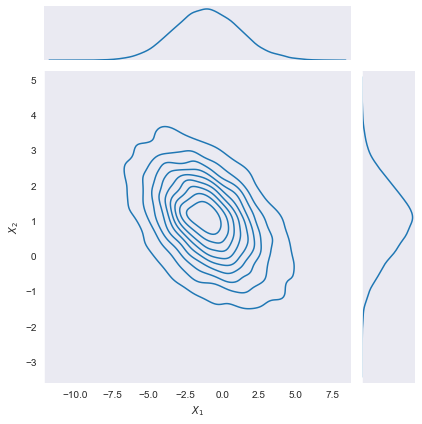

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 214.62it/s]


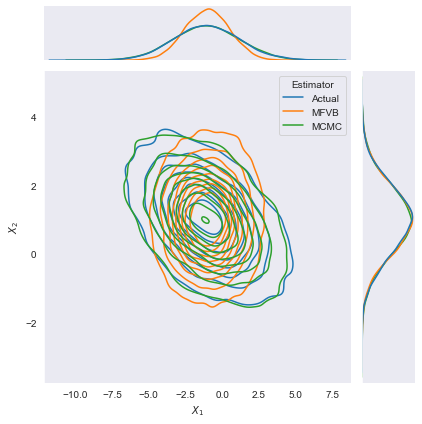

In [2]:
torch.manual_seed(0)

mean = torch.tensor([-1.,1.])
cov = torch.tensor([[5.,-1],[-1.,1.]])
biv = dist.MultivariateNormal(mean,cov).sample([n])
biv_error = dist.Normal(torch.zeros(2),torch.ones(2)*.1).sample([n])
biv_obs = biv + biv_error

framed = pd.DataFrame({"$X_1$":biv[:,0],"$X_2$":biv[:,1],"Estimator":"Actual"})
g = sns.jointplot(data=framed, x="$X_1$", y="$X_2$", kind="kde")
plt.savefig('sim1.png')
plt.show()

# MCMC

def MCMC_model(data):
    theta = pyro.sample("theta", dist.HalfCauchy(torch.ones(data.shape[1])))
    L_omega = pyro.sample("L_omega", dist.LKJCholesky(data.shape[1], torch.ones(())))
    L_Omega = torch.diag(theta.sqrt()).matmul(L_omega)
    mu = pyro.sample("mu",dist.Normal(torch.zeros(data.shape[1]),torch.ones(data.shape[1])))
    with pyro.plate("Obs", data.shape[0]):
        x = pyro.sample("X", dist.MultivariateNormal(mu, scale_tril=L_Omega), obs=data)
    return x

kernel = NUTS(MCMC_model, adapt_step_size=True)
posterior = MCMC(kernel, num_samples=200, warmup_steps=200)
posterior.run(biv_obs)
MCMC_samples = posterior.get_samples()

Mean = MCMC_samples['mu'].mean(0)
lower = MCMC_samples['theta'].mean(0).sqrt().diag().mm(MCMC_samples['L_omega'].mean(0))
Cov = lower.mm(lower.T)
MCMC_posterior_sample = dist.MultivariateNormal(Mean,Cov).sample([n])
framed_MCMC = pd.DataFrame({"$X_1$":MCMC_posterior_sample[:,0],"$X_2$":MCMC_posterior_sample[:,1],"Estimator":"MCMC"})

#MFVB

def SVI_model(data):
    with pyro.plate("Marginal",2):
        Mean = pyro.sample("Mean",dist.Normal(torch.zeros(2),torch.ones(2)*0.1))
        Var  = pyro.sample("Var" ,dist.Normal(torch.zeros(2),torch.ones(2)*0.1))
    with pyro.plate("Obs",data.shape[0]):
        X_1 = pyro.sample("X_1",dist.Normal(Mean[0],Var[0].exp()),obs = data[:,0])
        X_2 = pyro.sample("X_2",dist.Normal(Mean[1],Var[1].exp()),obs = data[:,1])

pyro.clear_param_store()
guide = AutoNormal(SVI_model)
elbo = TraceMeanField_ELBO(num_particles=1)
optim = pyro.optim.ClippedAdam({"lr":1e-1})
svi = SVI(SVI_model, guide, optim, loss=elbo)
for step in tqdm(range(10000)):
    new =svi.step(biv_obs)
    
MFVB_posterior = {k: v.data for k, v in pyro.get_param_store().items()}
MFVB_posterior_sample = dist.MultivariateNormal(MFVB_posterior['AutoNormal.locs.Mean'],
                                        torch.eye(2)*MFVB_posterior['AutoNormal.locs.Var'].exp()
                                       ).sample([n])
framed_MFVB = pd.DataFrame({"$X_1$":MFVB_posterior_sample[:,0],"$X_2$":MFVB_posterior_sample[:,1],"Estimator":"MFVB"})


comparison_frame = pd.concat((
    framed,
    framed_MFVB,
    framed_MCMC
)).reset_index()

sns.jointplot(data=comparison_frame, x="$X_1$", y="$X_2$",hue="Estimator", kind="kde")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
plt.savefig('sim2.png')
plt.show()

# Banana distribution

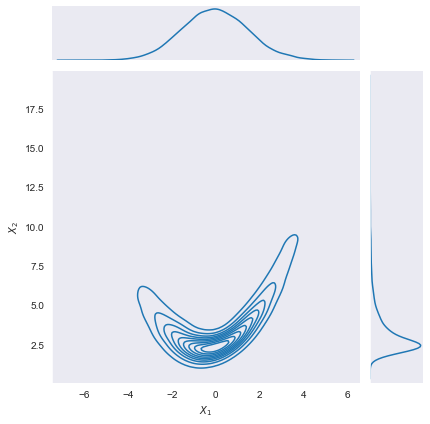

Sample: 100%|█████████████████████████████████████| 11000/11000 [03:24, 53.90it/s, step size=1.26e-01, acc. prob=0.954]


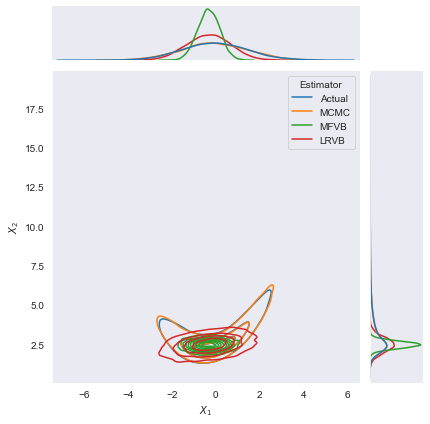

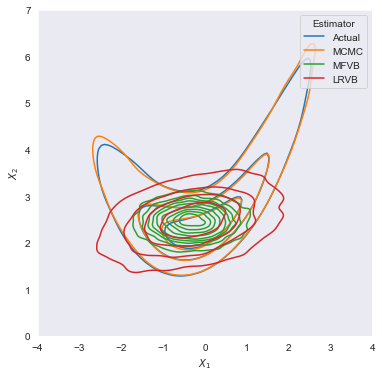

In [19]:
torch.manual_seed(0)

n = 10000

x1, x2 = torch.meshgrid([torch.linspace(0, 1, 100), torch.linspace(0, 1, 100)])
banana_sample = BananaShaped(1.5, 1).sample([n])

framed = pd.DataFrame({"$X_1$":banana_sample[:,0],"$X_2$":banana_sample[:,1],"Estimator":"Actual"})
g = sns.jointplot(data=framed, x="$X_1$", y="$X_2$", kind="kde")
plt.savefig('sim3.png')
plt.show()

def model():
    pyro.sample("x", BananaShaped(1.5, 1, 0.9))

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=n, warmup_steps=1000)
mcmc.run()
MCMC_samples = mcmc.get_samples()["x"]
framed_MCMC = pd.DataFrame({"$X_1$":MCMC_samples[:,0],"$X_2$":MCMC_samples[:,1],"Estimator":"MCMC"})

guide = AutoNormal(model, init_scale=0.05)
pyro.clear_param_store()
elbo = TraceMeanField_ELBO(num_particles=1)
optim = pyro.optim.ClippedAdam({"lr":1e-1})
svi = SVI(model, guide, optim, loss=elbo)
for step in range(n):
    new =svi.step()
with pyro.plate("N", n):
    MFVB_samples = guide()["x"].detach()
framed_MFVB = pd.DataFrame({"$X_1$":MFVB_samples[:,0],"$X_2$":MFVB_samples[:,1],"Estimator":"MFVB"})

guide_trace = poutine.trace(guide).get_trace()     
model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace()
loss = guide_trace.log_prob_sum() - model_trace.log_prob_sum()
H = hessian(loss,[
    pyro.param('AutoNormal.locs.x').unconstrained(),
    pyro.param('AutoNormal.scales.x').unconstrained()
])
Cov = -H.inverse()[:2,:2]

posterior = {k: v.data for k, v in pyro.get_param_store().items()}
Mean = posterior['AutoNormal.locs.x']

LRVB_posterior_sample = dist.MultivariateNormal(Mean,Cov + 1e-1*torch.eye(2)).sample([n])
framed_LRVB = pd.DataFrame({"$X_1$":LRVB_posterior_sample[:,0],"$X_2$":LRVB_posterior_sample[:,1],"Estimator":"LRVB"})

comparison_frame = pd.concat((
    framed,
    framed_MCMC,
    framed_MFVB,
    framed_LRVB
)).reset_index()

sns.jointplot(data=comparison_frame, x="$X_1$", y="$X_2$",hue="Estimator", kind="kde")
plt.savefig('sim4.png')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.kdeplot(data=comparison_frame, x="$X_1$", y="$X_2$",hue="Estimator",ax=ax)
ax.set_xlim(-4,4)
ax.set_ylim(0,7)
plt.savefig('sim5.png')
plt.show()

# Latent Var

## Model

In [15]:
torch.manual_seed(0)

n = 10000

mean = torch.tensor([-1.,1.])
cov = torch.tensor([[5.,-1],[-1.,1.]])
biv = dist.MultivariateNormal(mean,cov).sample([n])
biv_error = dist.Normal(torch.zeros(1),torch.ones(1)*.1).sample([n])
biv_obs = biv + biv_error
actual_frame = pd.DataFrame({"$X_1$":biv[:,0],"$X_2$":biv[:,1],"Estimator":"Actual"})

# sample marginals

Y_1 = dist.Poisson(biv_obs[:,0].exp()).sample([10]).T
Y_2 = dist.Exponential(biv_obs[:,1].exp()).sample([10]).T

def model(Y_1,Y_2):
    # sample global hyperparameters from prior
    Hyper = pyro.sample("Hyperparameters",dist.Normal(torch.zeros(6),torch.ones(6)).to_event(1))
    for i in pyro.plate("People",Y_1.shape[0]):
        # sample local parameters
        X_1   = pyro.sample("X_1_{}".format(i)  ,dist.Normal(Hyper[0],Hyper[1].exp()))
        X_2   = pyro.sample("X_2_{}".format(i)  ,dist.Normal(Hyper[2],Hyper[3].exp()))
        Sigma = pyro.sample("Sigma_{}".format(i),dist.Normal(Hyper[4],Hyper[5].exp()))
        
        # sample marginal observables
        pyro.sample("Y_1_{}".format(i), dist.Poisson(    (X_1+Sigma).exp()).expand([10]).to_event(1), obs = Y_1[i,:])
        pyro.sample("Y_2_{}".format(i), dist.Exponential((X_2+Sigma).exp()).expand([10]).to_event(1), obs = Y_2[i,:])

def guide(Y_1,Y_2):
    Globalparams = pyro.param("Global",torch.zeros(12))
    Localparams  = pyro.param("Local" ,torch.zeros(6).expand([Y_1.shape[0],6]))
    Hyper = pyro.sample("Hyperparameters",dist.Normal(Globalparams[:6],Globalparams[6:].exp()).to_event(1))
    for i in pyro.plate("People",Y_1.shape[0],subsample_size=100):
        # sample local parameters
        X_1   = pyro.sample("X_1_{}".format(i)  ,dist.Delta(Localparams[i,0]))
        X_2   = pyro.sample("X_2_{}".format(i)  ,dist.Delta(Localparams[i,2]))
        Sigma = pyro.sample("Sigma_{}".format(i),dist.Delta(Localparams[i,4]))
 

pyro.clear_param_store()
'''
elbo = TraceMeanField_ELBO(num_particles=1)
optim = pyro.optim.ClippedAdam({"lr":1e-2})
svi = SVI(model, guide, optim, loss=elbo)
for step in tqdm(range(3000)):
    new =svi.step(Y_1,Y_2)

posterior = {k: v.data for k, v in pyro.get_param_store().items()}
pickle.dump(posterior, open("MFVB_Posterior_2.p", "wb"))
'''

'\nelbo = TraceMeanField_ELBO(num_particles=1)\noptim = pyro.optim.ClippedAdam({"lr":1e-2})\nsvi = SVI(model, guide, optim, loss=elbo)\nfor step in tqdm(range(3000)):\n    new =svi.step(Y_1,Y_2)\n\nposterior = {k: v.data for k, v in pyro.get_param_store().items()}\npickle.dump(posterior, open("MFVB_Posterior_2.p", "wb"))\n'

## Building Blocks

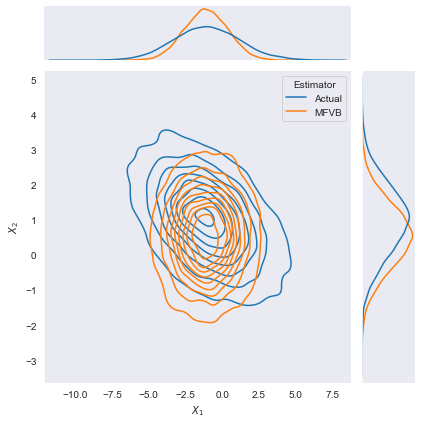

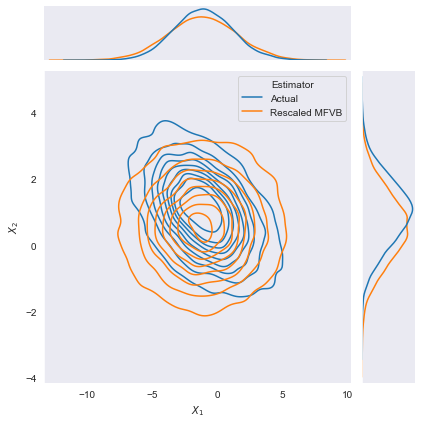

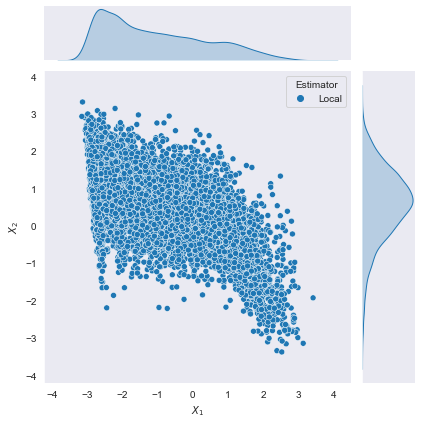

Residual distribution of local variables
Mean:  tensor(0.0282) SD:  tensor(1.0666)
Corr:  tensor(0.9213)
Mean:  tensor(0.4223) SD:  tensor(0.4274)
Corr:  tensor(0.9054)


In [16]:
torch.manual_seed(10)

# how bad are the marginals?
posterior = pickle.load(open("MFVB_Posterior_2.p", "rb"))

Global = posterior['Global']
Local = posterior['Local']

# MFVB fit
Marginal_1 = dist.Normal(Global[0],Global[1].exp()).sample([n])
Marginal_2 = dist.Normal(Global[2],Global[3].exp()).sample([n])

MFVB_frame = pd.DataFrame({"$X_1$":Marginal_1 ,"$X_2$":Marginal_2,"Estimator":"MFVB"})

comparison_frame = pd.concat((actual_frame, MFVB_frame)).reset_index()

sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim6.png')
plt.show()


# Covariance correction
guide_trace = poutine.trace(guide).get_trace(Y_1,Y_2)     
model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(Y_1,Y_2)
loss = guide_trace.log_prob_sum() - model_trace.log_prob_sum()
H = hessian(loss,pyro.param('Global').unconstrained())
Cov = -H.inverse()

level_1_1 = dist.MultivariateNormal(Global[0:2],Cov[0:2,0:2]+torch.eye(2)*1e-1).sample([1000])
level_1_2 = dist.Normal(level_1_1[:,0],level_1_1[:,1].exp()).sample([1000])
Marginal_1 = dist.Normal(Global[0],level_1_2.var(0).mean()).sample([n])

level_2_1 = dist.MultivariateNormal(Global[2:4],Cov[2:4,2:4]+torch.eye(2)*1e-1).sample([1000])
level_2_2 = dist.Normal(level_2_1[:,0],level_2_1[:,1].exp()).sample([1000])
Marginal_2 = dist.Normal(Global[2],level_2_2.var(0).mean()).sample([n])


Sigma_1 = level_1_2.var(0).mean()
Sigma_2 = level_2_2.var(0).mean()
Rescaling = torch.eye(2)*torch.tensor([Sigma_1,Sigma_2])
Original_mean = torch.tensor((Global[0],Global[2]))

R_MFVB_frame = pd.DataFrame({"$X_1$":Marginal_1 ,"$X_2$":Marginal_2,"Estimator":"Rescaled MFVB"})
comparison_frame = pd.concat((actual_frame, R_MFVB_frame)).reset_index()

sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim7.png')
plt.show()

# how bad are the point estimates of the local variables?
Local_frame = pd.DataFrame({"$X_1$":Local[:,0] ,"$X_2$":Local[:,2],"Estimator":"Local"})
sns.jointplot(data = Local_frame, x="$X_1$",  y="$X_2$", hue = "Estimator")
plt.savefig('sim8.png')
plt.show()
residuals_1 = biv[:,0]-Local[:,0]
residuals_2 = biv[:,1]-Local[:,2]
print("Residual distribution of local variables")
print("Mean: ",residuals_1.mean(),"SD: ",residuals_1.std())
print("Corr: ",torch.corrcoef(torch.concat((biv[:,0].reshape(1,-1),Local[:,0].reshape(1,-1)),axis=0))[0,1])
print("Mean: ",residuals_2.mean(),"SD: ",residuals_2.std())
print("Corr: ",torch.corrcoef(torch.concat((biv[:,1].reshape(1,-1),Local[:,2].reshape(1,-1)),axis=0))[0,1])

## Patch step

K =  2


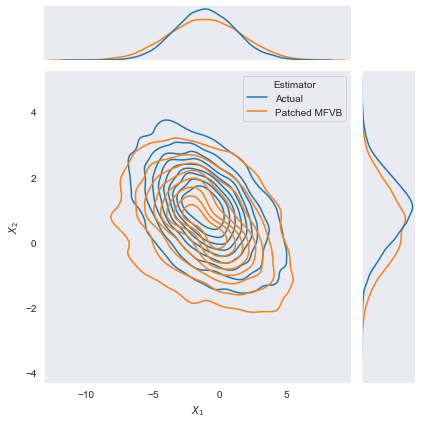

K =  5


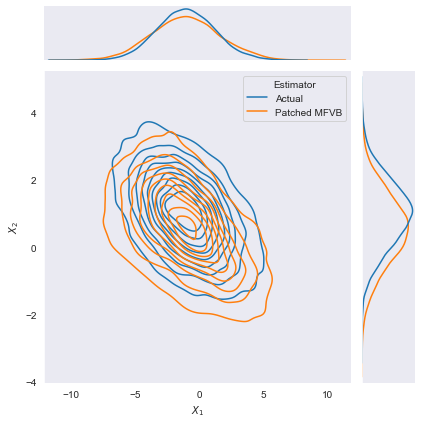

K =  10


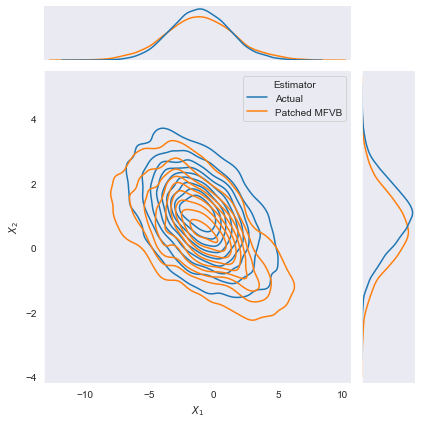

In [17]:
def patch_post_proc(Grid,K,Local):
    # get the OBSERVED percentiles 
    Local_1_bounds = Local["$X_1$"].quantile(np.array(Grid)).values
    Local_2_bounds = Local["$X_2$"].quantile(np.array(Grid)).values
    
    # make patching grid
    patches = np.zeros((len(Local_1_bounds),len(Local_2_bounds)))
    grid_importances = np.zeros((len(Local_1_bounds),len(Local_2_bounds)))
    for i in range(1,len(Grid)): 
        for j in range(1,len(Grid)): 
            subset_1 = (Local_frame["$X_1$"]>Local_1_bounds[i-1])&(Local_frame["$X_1$"]<Local_1_bounds[i])
            subset_2 = (Local_frame["$X_2$"]>Local_2_bounds[j-1])&(Local_frame["$X_2$"]<Local_2_bounds[j])
            if np.sum(subset_1&subset_2)>1:
                patches[i,j] = np.corrcoef(Local_frame["$X_1$"][subset_1&subset_2].values,Local_frame["$X_2$"][subset_1&subset_2].values)[0,1]
                grid_importances[i,j] = np.sum(subset_1&subset_2)
                
    # transform local estimates to standard biv normal and check if KL divergence is below threshold
    KL_update = np.zeros((len(Local_1_bounds),len(Local_2_bounds)))
    KL = torch.nn.KLDivLoss(reduction = 'batchmean', log_target=True)
    for i in range(1,len(Grid)): 
        for j in range(1,len(Grid)): 
            subset_1 = (Local_frame["$X_1$"]>Local_1_bounds[i-1])&(Local_frame["$X_1$"]<Local_1_bounds[i])
            subset_2 = (Local_frame["$X_2$"]>Local_2_bounds[j-1])&(Local_frame["$X_2$"]<Local_2_bounds[j])
            if np.sum(subset_1&subset_2)>1:
                S_obs = standardize(Local_frame[["$X_1$","$X_2$"]][subset_1&subset_2].values)
                corr = torch.eye(2) + (1-torch.eye(2))*patches[i,j]
                candidate = dist.MultivariateNormal(torch.zeros(2),corr+torch.eye(2)*1e-2)
                KL_update[i,j] = KL(input = torch.tensor(S_obs),target = candidate.sample([S_obs.shape[0]]))
    grid_importances = torch.tensor(grid_importances/grid_importances.sum())
    
    return patches[1:,1:],grid_importances[1:,1:],KL_update[1:,1:]



def Patched_sample(n_samples,patches,Grid,grid_importances,Rescaling,Original_mean):
    
    ## stage 1 - sample from grid with local importance weights
    if n_samples<=1000:
        grid_samples = torch.zeros(grid_importances.shape)
        for i in range(n_samples):
            U = torch.empty(2).uniform_(0,1)
            idx0 = K-(grid_importances.sum(1).cumsum(0)>U[0]).sum()
            idx1 = K-((grid_importances[idx0,:]/grid_importances[idx0,:].sum()).cumsum(0)>U[1]).sum()
            grid_samples[idx0,idx1]+=1
    # or if we're drawing a large sample, just get the expected counts to save time
    else:
        grid_samples = (grid_importances*n_samples).long()
          
    ## stage 2 - sample from each cell in global space
    D_1 = dist.Normal(Global[0],level_1_2.var(0).mean())
    D_2 = dist.Normal(Global[2],level_2_2.var(0).mean())
    percentiles_1 = D_1.icdf(Grid)
    percentiles_2 = D_2.icdf(Grid)
    patched_sample = torch.empty((1,2))
    for i in range(grid_samples.shape[0]):
        for j in range(grid_samples.shape[1]):
            sub_sample_size = grid_samples[i,j]
            corr = torch.eye(2) + (1-torch.eye(2))*patches[i,j]
            patched_covariance = Rescaling.matmul(corr).matmul(Rescaling)
            '''
            Oh, stats gods, I'm so deeply sorry for how I'm sampling this multivariate normal
            The truncated MVN is the devil himself
            '''
            step_dist = dist.MultivariateNormal(Original_mean,covariance_matrix = patched_covariance+torch.eye(2)*1e-2)
            raw_step_sample = step_dist.sample([100000])
            acceptance_1 = (percentiles_1[i]<raw_step_sample[:,0])&(raw_step_sample[:,0]<percentiles_1[i+1])
            acceptance_2 = (percentiles_2[j]<raw_step_sample[:,1])&(raw_step_sample[:,1]<percentiles_2[j+1])
            accepted = raw_step_sample[acceptance_1&acceptance_2]
            accepted_idx = torch.randperm(len(accepted))[:sub_sample_size]
            trimmed_accepted = accepted[accepted_idx,:]
            patched_sample = torch.cat((patched_sample,trimmed_accepted),axis=0)
    patched_sample = patched_sample[1:,:]
    return patched_sample

K = 2
print("K = ",K)
Grid = torch.arange(0,1+1/K,1/K)
patches,grid_importances,KL_update = patch_post_proc(Grid,K,Local_frame)
new_sample = Patched_sample(10000,patches,Grid,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim9.png')
plt.show()

K = 5
print("K = ",K)
Grid = torch.arange(0,1+1/K,1/K)
patches,grid_importances,KL_update = patch_post_proc(Grid,K,Local_frame)
new_sample = Patched_sample(10000,patches,Grid,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim10.png')
plt.show()

K = 10
print("K = ",K)
Grid = torch.arange(0,1+1/K,1/K)
patches,grid_importances,KL_update = patch_post_proc(Grid,K,Local_frame)
new_sample = Patched_sample(10000,patches,Grid,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim11.png')
plt.show()

## Correlation Multicalibration

Must reframe this into non-square grids

Single step
K =  2
[2.84317279 2.98065853 3.01068735 2.71931863]


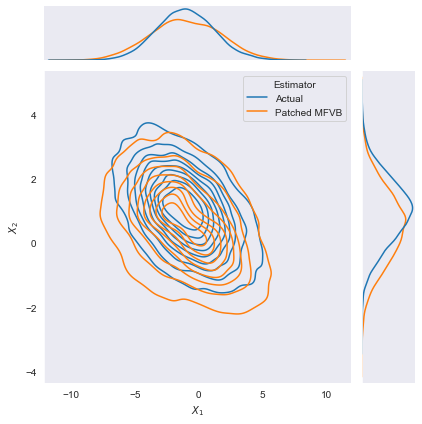

 12%|██████████▌                                                                         | 1/8 [00:00<00:01,  3.56it/s]


Done!
Steps taken:  2
Total partitions:  7
3.002187490463257


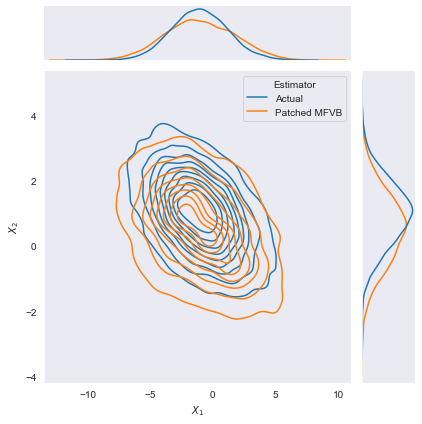

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


Steps taken:  8
Total partitions:  112
2.711698532104492


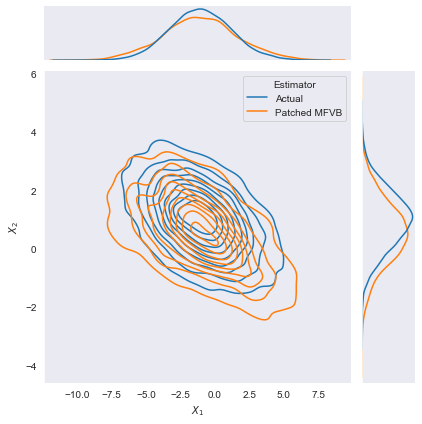

In [19]:
def patch_post_proc(Grid_bounds,Local):
    bounds_1_lower = Local["$X_1$"].quantile(np.array(Grid_bounds[:,2])).values
    bounds_1_higher= Local["$X_1$"].quantile(np.array(Grid_bounds[:,0])).values
    bounds_2_lower = Local["$X_2$"].quantile(np.array(Grid_bounds[:,3])).values
    bounds_2_higher= Local["$X_2$"].quantile(np.array(Grid_bounds[:,1])).values
    patches = np.zeros(Grid_bounds.shape[0])
    grid_importances = np.zeros(Grid_bounds.shape[0])
    for k in range(Grid_bounds.shape[0]):
        subset_1 = (Local_frame["$X_1$"]<bounds_1_higher[k])&(Local_frame["$X_1$"]>bounds_1_lower[k])
        subset_2 = (Local_frame["$X_2$"]<bounds_2_higher[k])&(Local_frame["$X_2$"]>bounds_2_lower[k])
        if np.sum(subset_1&subset_2)>1:
            patches[k] = np.corrcoef(Local_frame["$X_1$"][subset_1&subset_2].values,Local_frame["$X_2$"][subset_1&subset_2].values)[0,1]
            grid_importances[k] = np.sum(subset_1&subset_2)
    KL_update = np.zeros(Grid_bounds.shape[0])
    KL = torch.nn.KLDivLoss(reduction = 'batchmean', log_target=True)
    for k in range(Grid_bounds.shape[0]):
        subset_1 = (Local_frame["$X_1$"]<bounds_1_higher[k])&(Local_frame["$X_1$"]>bounds_1_lower[k])
        subset_2 = (Local_frame["$X_2$"]<bounds_2_higher[k])&(Local_frame["$X_2$"]>bounds_2_lower[k])
        if np.sum(subset_1&subset_2)>1:
            S_obs = standardize(Local_frame[["$X_1$","$X_2$"]][subset_1&subset_2].values)
            corr = torch.eye(2) + (1-torch.eye(2))*patches[k]
            candidate = dist.MultivariateNormal(torch.zeros(2),corr+torch.eye(2)*1e-2)
            test_KL = np.zeros(100)
            for ite in range(len(test_KL)):
                test_KL[ite] += KL(input = torch.tensor(S_obs),target = candidate.sample([S_obs.shape[0]]))
            KL_update[k] = test_KL.min()
    grid_importances = torch.tensor(grid_importances/grid_importances.sum())
    return patches,grid_importances,KL_update


def Patched_sample(n_samples,Grid_bounds,grid_importances,Rescaling,Original_mean):
    if n_samples<=1000:
        grid_samples = torch.zeros(grid_importances.shape)
        for i in range(n_samples):
            U = torch.empty(2).uniform_(0,1)
            loc = len(grid_importances)-(grid_importances.cumsum(0)>U).sum()
            grid_samples[loc]+=1
    else: grid_samples = (grid_importances*n_samples).long()
    D_1 = dist.Normal(Global[0],level_1_2.var(0).mean())
    D_2 = dist.Normal(Global[2],level_2_2.var(0).mean())
    bounds_1_lower = D_1.icdf(Grid_bounds[:,2])
    bounds_1_higher= D_1.icdf(Grid_bounds[:,0])
    bounds_2_lower = D_2.icdf(Grid_bounds[:,3])
    bounds_2_higher= D_2.icdf(Grid_bounds[:,1])
    patched_sample = torch.empty((1,2))
    for k in range(len(grid_samples)):
        sub_sample_size = grid_samples[k]
        corr = torch.eye(2) + (1-torch.eye(2))*patches[k]
        patched_covariance = Rescaling.matmul(corr).matmul(Rescaling)
        step_dist = dist.MultivariateNormal(Original_mean,covariance_matrix = patched_covariance+torch.eye(2)*1e-2)
        raw_step_sample = step_dist.sample([100000])
        acceptance_1 = (bounds_1_lower[k]<raw_step_sample[:,0])&(raw_step_sample[:,0]<bounds_1_higher[k])
        acceptance_2 = (bounds_2_lower[k]<raw_step_sample[:,1])&(raw_step_sample[:,1]<bounds_2_higher[k])
        accepted = raw_step_sample[acceptance_1&acceptance_2]
        accepted_idx = torch.randperm(len(accepted))[:sub_sample_size]
        trimmed_accepted = accepted[accepted_idx,:]
        patched_sample = torch.cat((patched_sample,trimmed_accepted),axis=0)
    patched_sample = patched_sample[1:,:]
    return patched_sample


# SPLIT(alpha):
def Corr_Multicalibrate(α,K,Local_frame,iters=8):
    Grid_bounds = torch.arange(1/K,1+1/K,1/K)
    Grid_bounds = torch.cat((Grid_bounds.repeat(1,len(Grid_bounds)).reshape(-1,1),Grid_bounds.repeat_interleave(len(Grid_bounds)).reshape(-1,1)),axis=1)
    Grid_bounds = torch.cat((Grid_bounds,Grid_bounds-1/K),axis=1)
    patches,grid_importances,KL_update = patch_post_proc(Grid_bounds, Local_frame)
    steps_taken = 0
    for step in tqdm(range(iters)):
        steps_taken+=1
        cont = 0
        for k in range(len(KL_update)):
            if KL_update[k]>α:
                cont+=1
                new_0 = (Grid_bounds[k][0]+Grid_bounds[k][2])/2
                new_1 = (Grid_bounds[k][1]+Grid_bounds[k][3])/2
                new_partition = torch.tensor([
                    [Grid_bounds[k][0],Grid_bounds[k][1]      ,new_0            ,new_1],
                    [new_0            ,new_1                  ,Grid_bounds[k][2],Grid_bounds[k][3]],
                    [new_0            ,Grid_bounds[k][1]      ,Grid_bounds[k][2],new_1],
                    [Grid_bounds[k][0],new_1                  ,new_0            ,Grid_bounds[k][3]]])
                Grid_bounds = torch.cat((Grid_bounds[:k,:], Grid_bounds[k+1:,:],new_partition),axis=0)
        patches,grid_importances,KL_update = patch_post_proc(Grid_bounds, Local_frame)
        if cont==0: 
            print("Done!")
            break
    print("Steps taken: ",steps_taken)
    print("Total partitions: ",len(patches))
    return Grid_bounds,patches,grid_importances,KL_update


K = 2
print("Single step")
print("K = ",K)
Grid_bounds = torch.arange(1/K,1+1/K,1/K)
Grid_bounds = torch.cat((Grid_bounds.repeat(1,len(Grid_bounds)).reshape(-1,1),Grid_bounds.repeat_interleave(len(Grid_bounds)).reshape(-1,1)),axis=1)
Grid_bounds = torch.cat((Grid_bounds,Grid_bounds-1/K),axis=1)

patches,grid_importances,KL_update = patch_post_proc(Grid_bounds, Local_frame)
print(KL_update)
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim12.png')
plt.show()

# single step is an improvement, but does not achieve multicalibration
# for multicalibration, perform split/merge by altering bounds until we are multicalibrated wrt to all partitions 

(α,K) = (3.,2) 
Grid_bounds,patches,grid_importances,KL_update = Corr_Multicalibrate(α,K,Local_frame)
print(KL_update.max())
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim13.png')
plt.show()

(α,K) = (2.5,2) 
Grid_bounds,patches,grid_importances,KL_update = Corr_Multicalibrate(α,K,Local_frame)
print(KL_update.max())
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim13.png')
plt.show()

## Banana posterior example

In [34]:
torch.manual_seed(0)

def model(Y_1,Y_2):
    # sample global hyperparameters from prior
    Hyper = pyro.sample("Hyperparameters",dist.Normal(torch.tensor([0.,0,1,0,0,0]),torch.ones(6)).to_event(1))
    for i in pyro.plate("People",Y_1.shape[0]):
        # sample local parameters
        X_1   = pyro.sample("X_1_{}".format(i)  ,dist.Normal(Hyper[0],Hyper[1].exp()))
        X_2   = pyro.sample("X_2_{}".format(i)  ,dist.Normal(Hyper[2],Hyper[3].exp()))
        Sigma = pyro.sample("Sigma_{}".format(i),dist.Normal(Hyper[4],Hyper[5].exp()))
        
        # sample marginal observables
        pyro.sample("Y_1_{}".format(i), dist.Poisson(    (X_1+Sigma).exp()).expand([10]).to_event(1), obs = Y_1[i,:])
        pyro.sample("Y_2_{}".format(i), dist.Exponential((X_2+Sigma).exp()).expand([10]).to_event(1), obs = Y_2[i,:])

def guide(Y_1,Y_2):
    Globalparams = pyro.param("Global",torch.zeros(12))
    Localparams  = pyro.param("Local" ,torch.tensor([0.,0,1,0,0,0]).expand([Y_1.shape[0],6]))
    Hyper = pyro.sample("Hyperparameters",dist.Normal(Globalparams[:6],Globalparams[6:].exp()).to_event(1))
    for i in pyro.plate("People",Y_1.shape[0],subsample_size=100):
        # sample local parameters
        X_1   = pyro.sample("X_1_{}".format(i)  ,dist.Delta(Localparams[i,0]))
        X_2   = pyro.sample("X_2_{}".format(i)  ,dist.Delta(Localparams[i,2]))
        Sigma = pyro.sample("Sigma_{}".format(i),dist.Delta(Localparams[i,4]))
 


n = 10000
x1, x2 = torch.meshgrid([torch.linspace(0, 1, 100), torch.linspace(0, 1, 100)])
banana_sample = BananaShaped(1., 1.).sample([n])
Y_1 = dist.Poisson(banana_sample[:,0].exp()).sample([10]).T
Y_2 = dist.Exponential(banana_sample[:,1].exp()).sample([10]).T

actual_frame = pd.DataFrame({"$X_1$":banana_sample[:,0],"$X_2$":banana_sample[:,1],"Estimator":"Actual"})

pyro.clear_param_store()
'''
elbo = TraceMeanField_ELBO(num_particles=1)
optim = pyro.optim.ClippedAdam({"lr":1e-1})
svi = SVI(model, guide, optim, loss=elbo)
for step in tqdm(range(3000)):
    new =svi.step(Y_1,Y_2)

posterior = {k: v.data for k, v in pyro.get_param_store().items()}
pickle.dump(posterior, open("MFVB_Posterior_Twisted.p", "wb"))
'''

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [16:57<00:00,  2.95it/s]


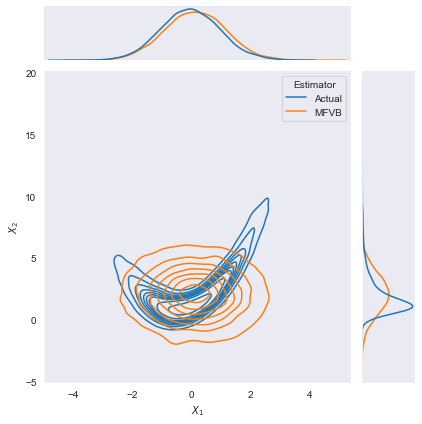

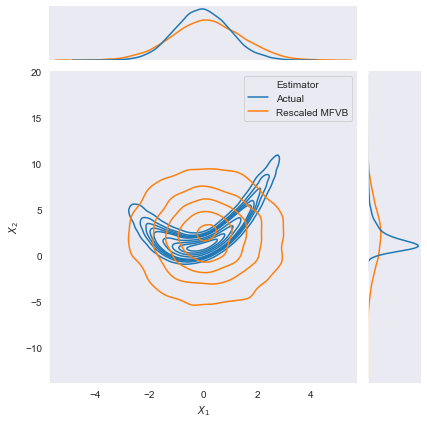

In [40]:
posterior = pickle.load(open("MFVB_Posterior_Twisted.p", "rb"))
Global = posterior['Global']
Local = posterior['Local']

Local_frame = pd.DataFrame({"$X_1$":Local[:,0] ,"$X_2$":Local[:,2],"Estimator":"Local"})

# MFVB fit
Marginal_1 = dist.Normal(Global[0],Global[1].exp()).sample([n])
Marginal_2 = dist.Normal(Global[2],Global[3].exp()).sample([n])
MFVB_frame = pd.DataFrame({"$X_1$":Marginal_1 ,"$X_2$":Marginal_2,"Estimator":"MFVB"})

comparison_frame = pd.concat((actual_frame, MFVB_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim14.png')
plt.show()

# Covariance correction
guide_trace = poutine.trace(guide).get_trace(Y_1,Y_2)     
model_trace = poutine.trace(poutine.replay(model, trace=guide_trace)).get_trace(Y_1,Y_2)
loss = guide_trace.log_prob_sum() - model_trace.log_prob_sum()
H = hessian(loss,pyro.param('Global').unconstrained())
Cov = -H.inverse()

level_1_1 = dist.MultivariateNormal(Global[0:2],Cov[0:2,0:2]+torch.eye(2)*1e-1).sample([1000])
level_1_2 = dist.Normal(level_1_1[:,0],level_1_1[:,1].exp()).sample([1000])
Marginal_1 = dist.Normal(Global[0],level_1_2.var(0).mean()).sample([n])

level_2_1 = dist.MultivariateNormal(Global[2:4],Cov[2:4,2:4]+torch.eye(2)*1e-1).sample([1000])
level_2_2 = dist.Normal(level_2_1[:,0],level_2_1[:,1].exp()).sample([1000])
Marginal_2 = dist.Normal(Global[2],level_2_2.var(0).mean()).sample([n])


Sigma_1 = level_1_2.var(0).mean()
Sigma_2 = level_2_2.var(0).mean()
Rescaling = torch.eye(2)*torch.tensor([Sigma_1,Sigma_2])
Original_mean = torch.tensor((Global[0],Global[2]))

R_MFVB_frame = pd.DataFrame({"$X_1$":Marginal_1 ,"$X_2$":Marginal_2,"Estimator":"Rescaled MFVB"})
comparison_frame = pd.concat((actual_frame, R_MFVB_frame)).reset_index()

sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim15.png')
plt.show()

K =  5


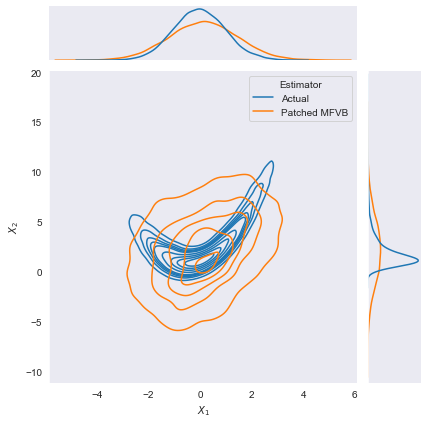

K =  20


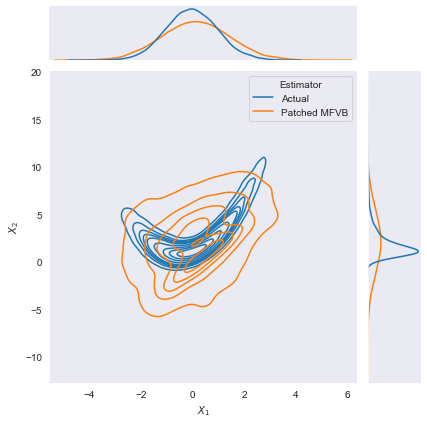

In [43]:
def patch_post_proc(Grid,K,Local):
    # get the OBSERVED percentiles 
    Local_1_bounds = Local["$X_1$"].quantile(np.array(Grid)).values
    Local_2_bounds = Local["$X_2$"].quantile(np.array(Grid)).values
    
    # make patching grid
    patches = np.zeros((len(Local_1_bounds),len(Local_2_bounds)))
    grid_importances = np.zeros((len(Local_1_bounds),len(Local_2_bounds)))
    for i in range(1,len(Grid)): 
        for j in range(1,len(Grid)): 
            subset_1 = (Local_frame["$X_1$"]>Local_1_bounds[i-1])&(Local_frame["$X_1$"]<Local_1_bounds[i])
            subset_2 = (Local_frame["$X_2$"]>Local_2_bounds[j-1])&(Local_frame["$X_2$"]<Local_2_bounds[j])
            if np.sum(subset_1&subset_2)>1:
                patches[i,j] = np.corrcoef(Local_frame["$X_1$"][subset_1&subset_2].values,Local_frame["$X_2$"][subset_1&subset_2].values)[0,1]
                grid_importances[i,j] = np.sum(subset_1&subset_2)
                
    # transform local estimates to standard biv normal and check if KL divergence is below threshold
    KL_update = np.zeros((len(Local_1_bounds),len(Local_2_bounds)))
    KL = torch.nn.KLDivLoss(reduction = 'batchmean', log_target=True)
    for i in range(1,len(Grid)): 
        for j in range(1,len(Grid)): 
            subset_1 = (Local_frame["$X_1$"]>Local_1_bounds[i-1])&(Local_frame["$X_1$"]<Local_1_bounds[i])
            subset_2 = (Local_frame["$X_2$"]>Local_2_bounds[j-1])&(Local_frame["$X_2$"]<Local_2_bounds[j])
            if np.sum(subset_1&subset_2)>1:
                S_obs = standardize(Local_frame[["$X_1$","$X_2$"]][subset_1&subset_2].values)
                corr = torch.eye(2) + (1-torch.eye(2))*patches[i,j]
                candidate = dist.MultivariateNormal(torch.zeros(2),corr+torch.eye(2)*1e-2)
                KL_update[i,j] = KL(input = torch.tensor(S_obs),target = candidate.sample([S_obs.shape[0]]))
    grid_importances = torch.tensor(grid_importances/grid_importances.sum())
    
    return patches[1:,1:],grid_importances[1:,1:],KL_update[1:,1:]



def Patched_sample(n_samples,patches,Grid,grid_importances,Rescaling,Original_mean):
    
    ## stage 1 - sample from grid with local importance weights
    if n_samples<=1000:
        grid_samples = torch.zeros(grid_importances.shape)
        for i in range(n_samples):
            U = torch.empty(2).uniform_(0,1)
            idx0 = K-(grid_importances.sum(1).cumsum(0)>U[0]).sum()
            idx1 = K-((grid_importances[idx0,:]/grid_importances[idx0,:].sum()).cumsum(0)>U[1]).sum()
            grid_samples[idx0,idx1]+=1
    # or if we're drawing a large sample, just get the expected counts to save time
    else:
        grid_samples = (grid_importances*n_samples).long()
          
    ## stage 2 - sample from each cell in global space
    D_1 = dist.Normal(Global[0],level_1_2.var(0).mean())
    D_2 = dist.Normal(Global[2],level_2_2.var(0).mean())
    percentiles_1 = D_1.icdf(Grid)
    percentiles_2 = D_2.icdf(Grid)
    patched_sample = torch.empty((1,2))
    for i in range(grid_samples.shape[0]):
        for j in range(grid_samples.shape[1]):
            sub_sample_size = grid_samples[i,j]
            corr = torch.eye(2) + (1-torch.eye(2))*patches[i,j]
            patched_covariance = Rescaling.matmul(corr).matmul(Rescaling)
            '''
            Oh, stats gods, I'm so deeply sorry for how I'm sampling this multivariate normal
            The truncated MVN is the devil himself
            '''
            step_dist = dist.MultivariateNormal(Original_mean,covariance_matrix = patched_covariance+torch.eye(2)*1e-2)
            raw_step_sample = step_dist.sample([100000])
            acceptance_1 = (percentiles_1[i]<raw_step_sample[:,0])&(raw_step_sample[:,0]<percentiles_1[i+1])
            acceptance_2 = (percentiles_2[j]<raw_step_sample[:,1])&(raw_step_sample[:,1]<percentiles_2[j+1])
            accepted = raw_step_sample[acceptance_1&acceptance_2]
            accepted_idx = torch.randperm(len(accepted))[:sub_sample_size]
            trimmed_accepted = accepted[accepted_idx,:]
            patched_sample = torch.cat((patched_sample,trimmed_accepted),axis=0)
    patched_sample = patched_sample[1:,:]
    return patched_sample

K = 5
print("K = ",K)
Grid = torch.arange(0,1+1/K,1/K)
patches,grid_importances,KL_update = patch_post_proc(Grid,K,Local_frame)
new_sample = Patched_sample(10000,patches,Grid,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim16.png')
plt.show()

K = 20
print("K = ",K)
Grid = torch.arange(0,1+1/K,1/K)
patches,grid_importances,KL_update = patch_post_proc(Grid,K,Local_frame)
new_sample = Patched_sample(10000,patches,Grid,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim17.png')
plt.show()

Single step
K =  2
[2.89987659 2.88073277 2.89712977 3.00559878]


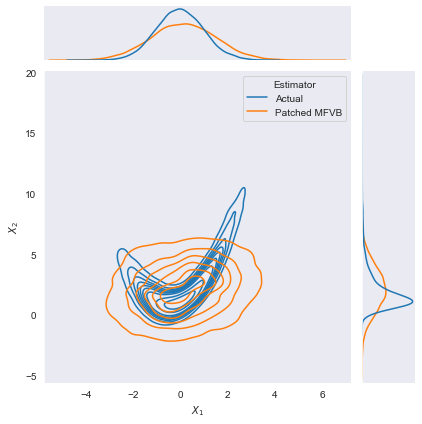

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]


Done!
Steps taken:  1
Total partitions:  4
2.96355938911438


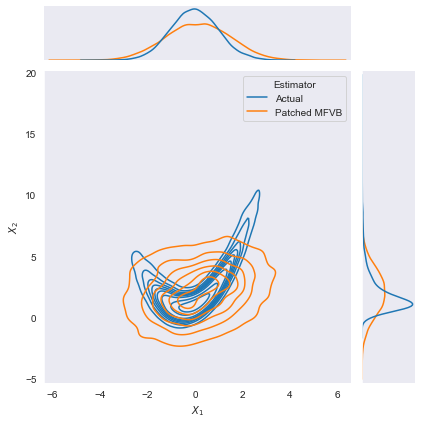

 69%|█████████████████████████████████████████████████████████▍                         | 9/13 [00:10<00:04,  1.11s/it]

Done!
Steps taken:  10
Total partitions:  97
2.612513542175293


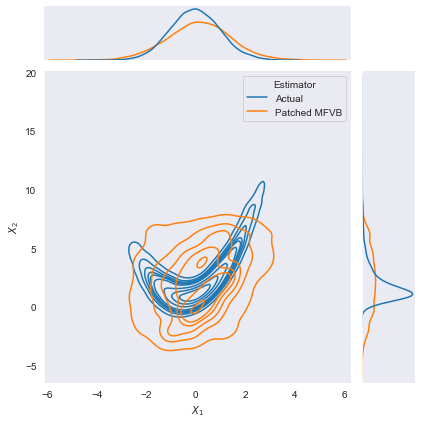

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.81s/it]


Steps taken:  13
Total partitions:  358
2.432861804962158


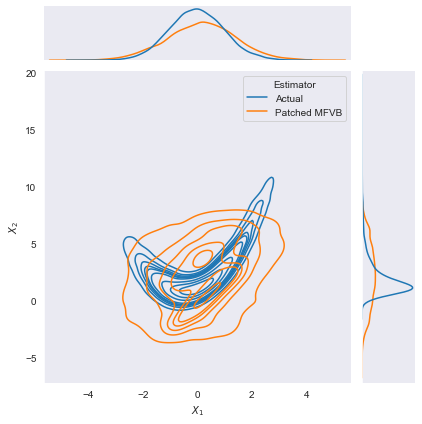

In [58]:
torch.manual_seed(0)

def patch_post_proc(Grid_bounds,Local):
    bounds_1_lower = Local["$X_1$"].quantile(np.array(Grid_bounds[:,2])).values
    bounds_1_higher= Local["$X_1$"].quantile(np.array(Grid_bounds[:,0])).values
    bounds_2_lower = Local["$X_2$"].quantile(np.array(Grid_bounds[:,3])).values
    bounds_2_higher= Local["$X_2$"].quantile(np.array(Grid_bounds[:,1])).values
    patches = np.zeros(Grid_bounds.shape[0])
    grid_importances = np.zeros(Grid_bounds.shape[0])
    for k in range(Grid_bounds.shape[0]):
        subset_1 = (Local_frame["$X_1$"]<bounds_1_higher[k])&(Local_frame["$X_1$"]>bounds_1_lower[k])
        subset_2 = (Local_frame["$X_2$"]<bounds_2_higher[k])&(Local_frame["$X_2$"]>bounds_2_lower[k])
        if np.sum(subset_1&subset_2)>1:
            patches[k] = np.corrcoef(Local_frame["$X_1$"][subset_1&subset_2].values,Local_frame["$X_2$"][subset_1&subset_2].values)[0,1]
            grid_importances[k] = np.sum(subset_1&subset_2)
    KL_update = np.zeros(Grid_bounds.shape[0])
    KL = torch.nn.KLDivLoss(reduction = 'batchmean', log_target=True)
    for k in range(Grid_bounds.shape[0]):
        subset_1 = (Local_frame["$X_1$"]<bounds_1_higher[k])&(Local_frame["$X_1$"]>bounds_1_lower[k])
        subset_2 = (Local_frame["$X_2$"]<bounds_2_higher[k])&(Local_frame["$X_2$"]>bounds_2_lower[k])
        if np.sum(subset_1&subset_2)>1:
            S_obs = standardize(Local_frame[["$X_1$","$X_2$"]][subset_1&subset_2].values)
            corr = torch.eye(2) + (1-torch.eye(2))*patches[k]
            candidate = dist.MultivariateNormal(torch.zeros(2),corr+torch.eye(2)*1e-2)
            test_KL = np.zeros(100)
            for ite in range(len(test_KL)):
                test_KL[ite] += KL(input = torch.tensor(S_obs),target = candidate.sample([S_obs.shape[0]]))
            KL_update[k] = test_KL.min()
    grid_importances = torch.tensor(grid_importances/grid_importances.sum())
    return patches,grid_importances,KL_update


def Patched_sample(n_samples,Grid_bounds,grid_importances,Rescaling,Original_mean):
    if n_samples<=1000:
        grid_samples = torch.zeros(grid_importances.shape)
        for i in range(n_samples):
            U = torch.empty(2).uniform_(0,1)
            loc = len(grid_importances)-(grid_importances.cumsum(0)>U).sum()
            grid_samples[loc]+=1
    else: grid_samples = (grid_importances*n_samples).long()
    D_1 = dist.Normal(Global[0],level_1_2.var(0).mean())
    D_2 = dist.Normal(Global[2],level_2_2.var(0).mean())
    bounds_1_lower = D_1.icdf(Grid_bounds[:,2])
    bounds_1_higher= D_1.icdf(Grid_bounds[:,0])
    bounds_2_lower = D_2.icdf(Grid_bounds[:,3])
    bounds_2_higher= D_2.icdf(Grid_bounds[:,1])
    patched_sample = torch.empty((1,2))
    for k in range(len(grid_samples)):
        sub_sample_size = grid_samples[k]
        corr = torch.eye(2) + (1-torch.eye(2))*patches[k]
        patched_covariance = Rescaling.matmul(corr).matmul(Rescaling)
        step_dist = dist.MultivariateNormal(Original_mean,covariance_matrix = patched_covariance+torch.eye(2)*1e-2)
        raw_step_sample = step_dist.sample([100000])
        acceptance_1 = (bounds_1_lower[k]<raw_step_sample[:,0])&(raw_step_sample[:,0]<bounds_1_higher[k])
        acceptance_2 = (bounds_2_lower[k]<raw_step_sample[:,1])&(raw_step_sample[:,1]<bounds_2_higher[k])
        accepted = raw_step_sample[acceptance_1&acceptance_2]
        accepted_idx = torch.randperm(len(accepted))[:sub_sample_size]
        trimmed_accepted = accepted[accepted_idx,:]
        patched_sample = torch.cat((patched_sample,trimmed_accepted),axis=0)
    patched_sample = patched_sample[1:,:]
    return patched_sample


# SPLIT(alpha):
def Corr_Multicalibrate(α,K,Local_frame,iters=13):
    Grid_bounds = torch.arange(1/K,1+1/K,1/K)
    Grid_bounds = torch.cat((Grid_bounds.repeat(1,len(Grid_bounds)).reshape(-1,1),Grid_bounds.repeat_interleave(len(Grid_bounds)).reshape(-1,1)),axis=1)
    Grid_bounds = torch.cat((Grid_bounds,Grid_bounds-1/K),axis=1)
    patches,grid_importances,KL_update = patch_post_proc(Grid_bounds, Local_frame)
    steps_taken = 0
    for step in tqdm(range(iters)):
        steps_taken+=1
        cont = 0
        for k in range(len(KL_update)):
            if KL_update[k]>α:
                cont+=1
                new_0 = (Grid_bounds[k][0]+Grid_bounds[k][2])/2
                new_1 = (Grid_bounds[k][1]+Grid_bounds[k][3])/2
                new_partition = torch.tensor([
                    [Grid_bounds[k][0],Grid_bounds[k][1]      ,new_0            ,new_1],
                    [new_0            ,new_1                  ,Grid_bounds[k][2],Grid_bounds[k][3]],
                    [new_0            ,Grid_bounds[k][1]      ,Grid_bounds[k][2],new_1],
                    [Grid_bounds[k][0],new_1                  ,new_0            ,Grid_bounds[k][3]]])
                Grid_bounds = torch.cat((Grid_bounds[:k,:], Grid_bounds[k+1:,:],new_partition),axis=0)
        patches,grid_importances,KL_update = patch_post_proc(Grid_bounds, Local_frame)
        if cont==0: 
            print("Done!")
            break
    print("Steps taken: ",steps_taken)
    print("Total partitions: ",len(patches))
    return Grid_bounds,patches,grid_importances,KL_update


#Rescaling[1,1] = actual_frame["$X_2$"].std()

K = 2
print("Single step")
print("K = ",K)
Grid_bounds = torch.arange(1/K,1+1/K,1/K)
Grid_bounds = torch.cat((Grid_bounds.repeat(1,len(Grid_bounds)).reshape(-1,1),Grid_bounds.repeat_interleave(len(Grid_bounds)).reshape(-1,1)),axis=1)
Grid_bounds = torch.cat((Grid_bounds,Grid_bounds-1/K),axis=1)

patches,grid_importances,KL_update = patch_post_proc(Grid_bounds, Local_frame)
print(KL_update)
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim18.png')
plt.show()

# single step is an improvement, but does not achieve multicalibration
# for multicalibration, perform split/merge by altering bounds until we are multicalibrated wrt to all partitions 

(α,K) = (3.,2) 
Grid_bounds,patches,grid_importances,KL_update = Corr_Multicalibrate(α,K,Local_frame)
print(KL_update.max())
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim19.png')
plt.show()

(α,K) = (2.5,2) 
Grid_bounds,patches,grid_importances,KL_update = Corr_Multicalibrate(α,K,Local_frame)
print(KL_update.max())
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim20.png')
plt.show()

(α,K) = (2.,2) 
Grid_bounds,patches,grid_importances,KL_update = Corr_Multicalibrate(α,K,Local_frame)
print(KL_update.max())
new_sample = Patched_sample(10000,Grid_bounds,grid_importances,Rescaling,Original_mean)
patched_frame = pd.DataFrame({"$X_1$":new_sample[:,0],"$X_2$":new_sample[:,1],"Estimator":"Patched MFVB"})
comparison_frame = pd.concat((actual_frame,patched_frame)).reset_index()
sns.jointplot(data = comparison_frame, x="$X_1$",  y="$X_2$", kind="kde",hue = "Estimator")
plt.savefig('sim21.png')
plt.show()